In [6]:
!python3 -m pip install --quiet degirum
!curl -s https://cdn.pixabay.com/photo/2018/04/05/17/22/kettlebell-3293481_1280.jpg -o ThreePersons.jpg
!pip install --ignore-installed Pillow==9.2.0
# Restart runtime when prompted
# skip the current cell and proceed to next after restart

  Using cached Pillow-9.2.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.2 MB)


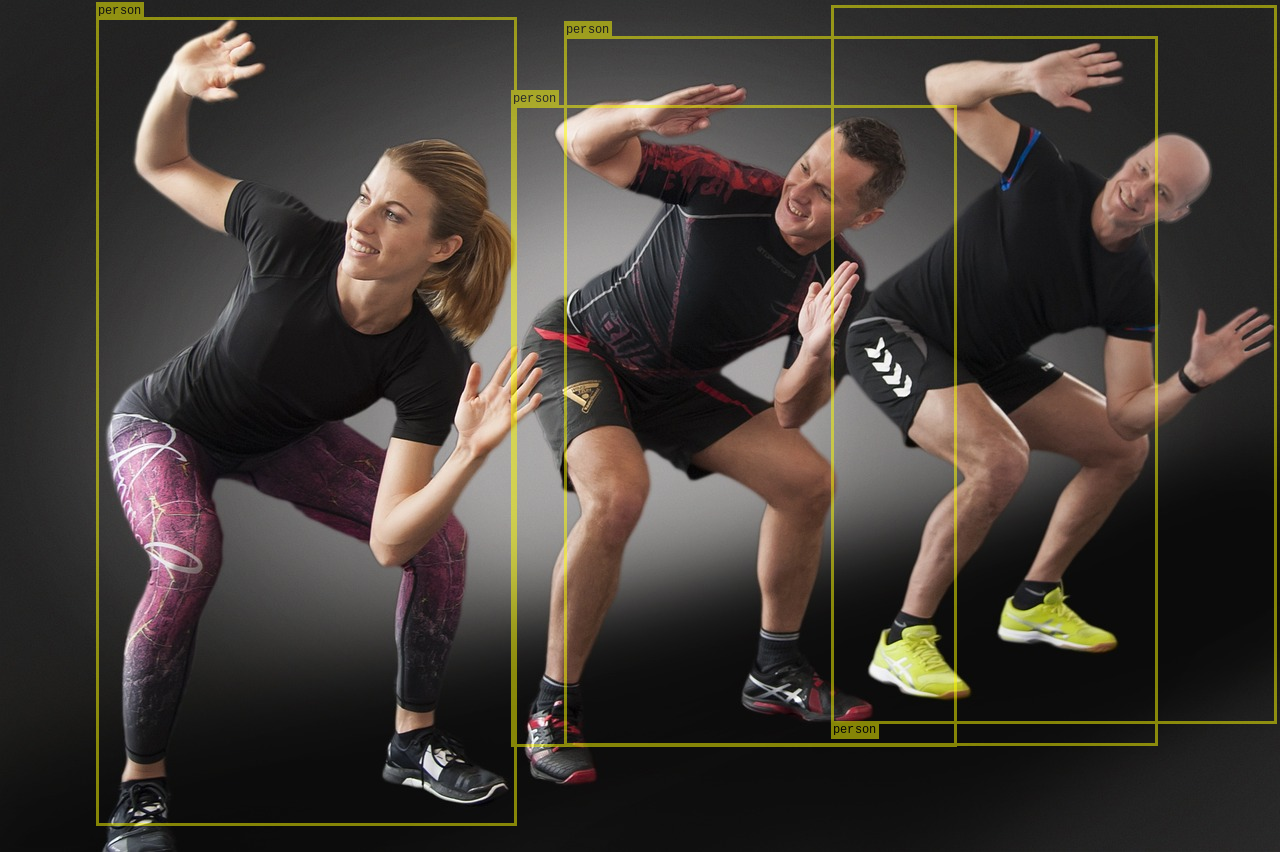

In [2]:
import degirum as dg

zoo = dg.connect(dg.CLOUD, 'https://cs.degirum.com/degirum/public', 'dg_CAMfjDcMpgUGsXzkSYqdLAA2CJQHvH95yu4Bk')
model = zoo.load_model('yolo_v5s_coco--512x512_quant_n2x_orca_1')
model.measure_time = True
res = model('ThreePersons.jpg')
res.image_overlay
# model predictions
# res.results

In [ ]:
stats = model.time_stats()
print("{:<27} - {}".format("PythonPreprocessDuration_ms", stats["PythonPreprocessDuration_ms"].avg))
print("{:<27} - {}".format("CoreInferenceDuration_ms", stats["CoreInferenceDuration_ms"].avg))
print("{:<27} - {}".format("CoreLoadResultDuration_ms", stats["CoreLoadResultDuration_ms"].avg))
print("{:<27} - {}".format("CorePostprocessDuration_ms", stats["CorePostprocessDuration_ms"].avg))
print("{:<27} - {}".format("CorePreprocessDuration_ms", stats["CorePreprocessDuration_ms"].avg))
print("{:<27} - {}".format("FrameTotalDuration_ms", stats["FrameTotalDuration_ms"].avg))

PythonPreprocessDuration_ms - 23.263719
CoreInferenceDuration_ms    - 15.07832
CoreLoadResultDuration_ms   - 0.152759
CorePostprocessDuration_ms  - 0.881813
CorePreprocessDuration_ms   - 5.695116
FrameTotalDuration_ms       - 902.953137


In [ ]:
# list all AI models available for inference
zoo.list_models()

['deeplab_seg--513x513_quant_n2x_cpu_1',
 'deeplab_seg--513x513_quant_n2x_orca_1',
 'efficientdet_lite1_coco--384x384_quant_n2x_cpu_1',
 'efficientdet_lite1_coco--384x384_quant_n2x_orca_1',
 'efficientnet_em_imagenet--240x240_quant_n2x_cpu_1',
 'efficientnet_em_imagenet--240x240_quant_n2x_orca_1',
 'efficientnet_es_imagenet--224x224_quant_n2x_cpu_1',
 'efficientnet_es_imagenet--224x224_quant_n2x_orca_1',
 'mobiledet_coco--320x320_quant_n2x_cpu_1',
 'mobiledet_coco--320x320_quant_n2x_orca_1',
 'mobilenet_v1_imagenet--224x224_quant_n2x_cpu_1',
 'mobilenet_v1_imagenet--224x224_quant_n2x_orca_1',
 'mobilenet_v1_posenet_coco_keypoints--353x481_quant_n2x_cpu_1',
 'mobilenet_v1_posenet_coco_keypoints--353x481_quant_n2x_orca_1',
 'mobilenet_v1_yamnet_sound_cls--96x64_quant_n2x_cpu_1',
 'mobilenet_v1_yamnet_sound_cls--96x64_quant_n2x_orca_1',
 'mobilenet_v2_generic_object--224x224_quant_n2x_cpu_1',
 'mobilenet_v2_generic_object--224x224_quant_n2x_orca_1',
 'mobilenet_v2_hand_landmarks--224x224_

# Example of how to pipeline two models
**Face Mask Detection Pipelined**


---

In [ ]:
# load models for DeGirum Orca AI accelerator
# (change model name to "...n2x_cpu_1" to run it on CPU)
face_det_model = zoo.load_model("yolo_v5s_face_det--512x512_quant_n2x_orca_1")
mask_det_model = zoo.load_model("mobilenet_v2_mask_yn_cls--224x224_float_n2x_orca_1")

# adjust some model properties
face_det_model.output_confidence_threshold = 0.7
face_det_model.overlay_font_scale = 1.5
face_det_model.overlay_alpha = 1
face_det_model.image_backend = 'pil'
mask_det_model.overlay_show_labels = True
mask_det_model.overlay_font_scale = 1.5
mask_det_model.overlay_alpha = 1
mask_det_model.output_top_k = 1
mask_det_model.image_backend = 'pil'

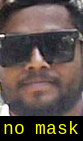

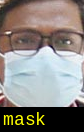

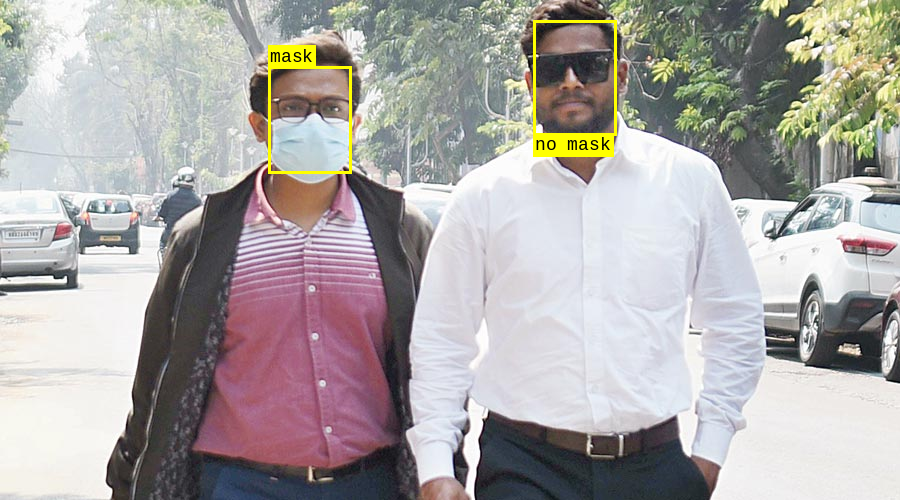

In [ ]:
# detect persons
!curl -s https://raw.githubusercontent.com/DeGirum/PySDKExamples/main/images/Mask1.jpg -o Mask1.jpg
faces = face_det_model('Mask1.jpg')

# for each detected face detect mask
with mask_det_model: # performance optimization to keep connection to mask_det_model open
    for face in faces.results:
        face_box = faces.image.crop(face['bbox'])
        mask = mask_det_model(face_box)
        face["label"] = mask.results[0]["label"]
        display(mask.image_overlay)

# display combined results
display(faces.image_overlay)

**License Plate Detection & Recognition Pipelined**


---




In [ ]:
# load models for DeGirum Orca AI accelerator
# (change model name to "...n2x_cpu_1" to run it on CPU)
lp_det_model = zoo.load_model("yolo_v5s_lp_det--512x512_quant_n2x_orca_1")
lp_ocr_model = zoo.load_model("yolo_v5s_lp_ocr--256x256_quant_n2x_orca_1")

# adjust some model properties
lp_det_model.output_confidence_threshold = 0.7
lp_det_model.overlay_font_scale = 1.5
lp_det_model.overlay_alpha = 1
lp_det_model.image_backend = 'pil'
lp_ocr_model.overlay_show_labels = True
lp_ocr_model.overlay_font_scale = 1.5
lp_ocr_model.overlay_alpha = 1
lp_ocr_model.output_top_k = 1
lp_ocr_model.image_backend = 'pil'

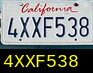

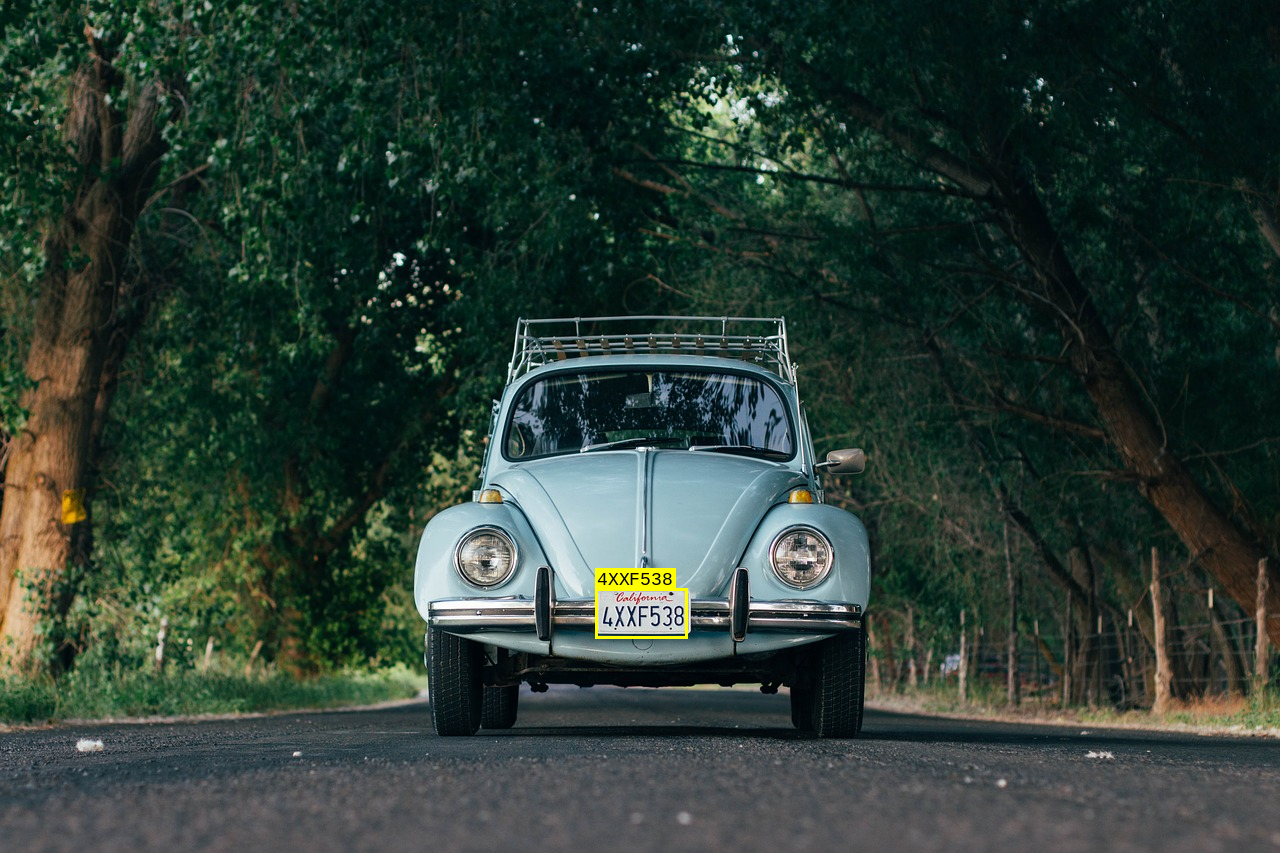

In [ ]:
# detect license plates
!curl -s https://raw.githubusercontent.com/DeGirum/PySDKExamples/main/images/Car.jpg -o Car.jpg
license_plates = lp_det_model('Car.jpg')

# for each detected license place detect  characters
with lp_det_model: # performance optimization to keep connection to lp_det_model open
    for plate in license_plates.results:
        lp_box = license_plates.image.crop(plate['bbox'])
        ocr_plates = lp_ocr_model(lp_box)
        plate["label"] = ocr_plates.results[0]["label"]
        display(ocr_plates.image_overlay)

# display combined results
display(license_plates.image_overlay)

**Object Detection on Video**


---

In [5]:
!curl -s https://raw.githubusercontent.com/DeGirum/PySDKExamples/main/images/Traffic.mp4 -o Traffic.mp4
!curl -s https://raw.githubusercontent.com/DeGirum/PySDKExamples/main/mytools.py -o mytools.py

import cv2
import degirum as dg, mytools
from IPython.display import HTML
from pathlib import Path
from base64 import b64encode

zoo = dg.connect(dg.CLOUD, 'https://cs.degirum.com/degirum/public', 'dg_CAMfjDcMpgUGsXzkSYqdLAA2CJQHvH95yu4Bk')
model = zoo.load_model('yolo_v5s_coco--512x512_quant_n2x_orca_1')
model.image_backend = 'opencv' # select OpenCV backend: needed to have overlay image in OpenCV format
model.input_numpy_colorspace = 'BGR'
model.overlay_show_probabilities = True
model.overlay_line_width = 1
model._model_parameters.InputImgFmt = ['JPEG']

orig_path = Path('Traffic.mp4')
ann_path = orig_path.with_name(orig_path.stem + '_annotated' + orig_path.suffix)

# AI prediction loop
# Press 'x' or 'q' to stop
with mytools.Display('AI Camera') as display, \
     mytools.open_video_stream('Traffic.mp4') as stream, \
     mytools.open_video_writer(str(ann_path), stream.get(cv2.CAP_PROP_FRAME_WIDTH), stream.get(cv2.CAP_PROP_FRAME_HEIGHT)) as writer:

    progress = mytools.Progress(int(stream.get(cv2.CAP_PROP_FRAME_COUNT)))
    for res in model.predict_batch(mytools.video_source(stream, report_error=False)):
        img = res.image_overlay
        # writer.write(img)
        progress.step()

In [ ]:
# view procession video
mp4 = open(ann_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=800 controls><source src="{data_url}" type="video/mp4">
</video>""")